# Plot Connectomes

In [2]:
import nilearn.plotting as nip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as  cm


Bad key "text.kerning_factor" on line 4 in
/home/andrea/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [3]:
power2011 = pd.read_csv("../rsfmri/bin/power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

,ROI,X,Y,Z,Network,Color,NetworkName
0,1,-25,-98,-12,-1,White,Uncertain
1,2,27,-97,-13,-1,White,Uncertain
2,3,24,32,-18,-1,White,Uncertain
3,4,-56,-45,-24,-1,White,Uncertain
4,5,8,41,-24,-1,White,Uncertain
...,...,...,...,...,...,...,...
259,260,-27,-71,37,12,Green,Dorsal attention
260,261,-32,-1,54,12,Green,Dorsal attention
261,262,-42,-60,-9,12,Green,Dorsal attention
262,263,-17,-59,64,12,Green,Dorsal attention


### Visualize the Brain Parcellation

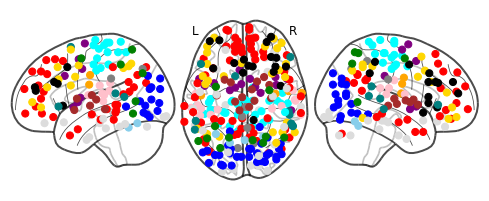

In [4]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]

def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)

img = nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

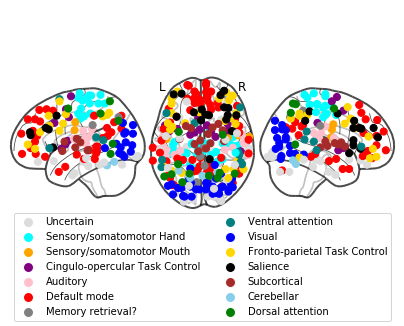

In [5]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(7,5))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr', axes=axs)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=2)
plt.savefig("figures/power2011.png", figsize=(7, 5))
plt.show()

### Visualize the connectome matrix

We can visualize the connectome matrix for the 62 participants. First, we load the data:

In [6]:
R = np.zeros((264, 264, 61))
PR = np.zeros((264, 264, 61))

index = 0
for ii in range(1, 63):
    subj = "sub-%03d" % (ii,)
    if ii != 8:
        R[:,:,index]=np.loadtxt("../rsfmri/%s/R_py.txt" % (subj,))
        PR[:,:,index]=np.loadtxt("../rsfmri/%s/PR_py.txt" % (subj,))
        index += 1

Then, we visualize it as a matrix

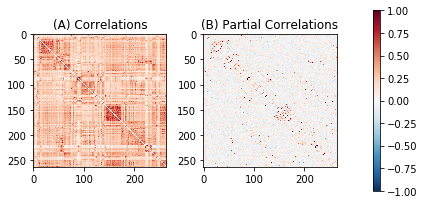

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [20, 20, 1]})
mR = np.mean(R, 2)
mPR = np.mean(PR, 2)

for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

im = axs[0].imshow(mR, vmin=-1, vmax=1, cmap="RdBu_r")
axs[0].set_title("(A) Correlations")
fig.colorbar(im, cax=axs[2])
axs[1].imshow(mPR, vmin=-0.25, vmax=0.25, cmap="RdBu_r")
axs[1].set_title("(B) Partial Correlations")
#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png")

### Creating a generic function

Here we assemble all of the steps above into a single function.

In [8]:
### Create a Handy Function

def connectome_visualization(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    # Load the data
    data = pd.read_csv("%s.csv" % (variable,))
    
    # Extract Regions
    ROIs = []

    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    connectome = np.zeros((N, N))
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
            
    plt.imshow(connectome)
    plt.title("Connectome (Beta values)")
    plt.show()

    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)

    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    nip.plot_connectome(connectome, coords, colorbar=True,
                    title=r"Predictors of %s" % (name,), 
                    black_bg=blackbg, node_color=colors)
    plt.savefig("%s.png" % (variable,))
    nip.show()

    nip.plot_connectome_strength(connectome, coords,
                                 title=r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,))
    nip.show()
    
    return connectome, coords, colors

## Rate of Forgetting $\alpha$

We use the new function to plot a different variable, the Rate of Forgetting $\alpha$.

Now some prettier visualizations

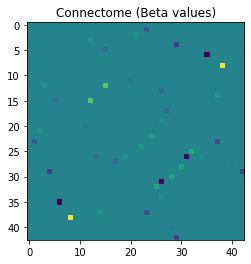

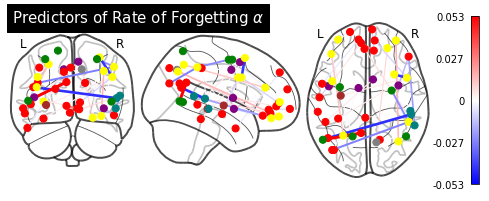

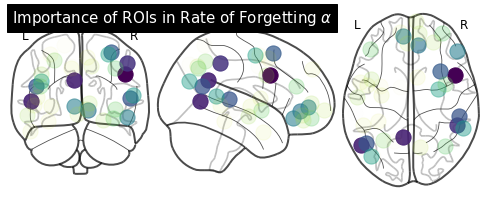

In [9]:
c, nc, cols = connectome_visualization("alpha3", name=r"Rate of Forgetting $\alpha$", blackbg=False)
nip.view_connectome(c, nc, colorbar_fontsize=8)

Some prettier visualizations. First, we need to get the network names and colors.

In [10]:
alpha = pd.read_csv("alpha3.csv")
alpha

,index,network,network_names,connection,censor,Beta
0,69400,10-12,Subcortical-Dorsal attention,232-263,True,-1.091151e-03
1,22755,3-5,Cingulo-opercular Task Control-Default mode,51-87,True,-9.908078e-04
2,28039,3-5,Cingulo-opercular Task Control-Default mode,55-107,True,5.306107e-03
3,34374,3-5,Cingulo-opercular Task Control-Default mode,54-131,True,4.299638e-03
4,36484,3-5,Cingulo-opercular Task Control-Default mode,52-139,True,-1.414369e-02
5,62647,5-11,Default mode-Ventral attention,79-238,True,-4.321418e-02
6,62926,5-11,Default mode-Ventral attention,94-239,True,9.946554e-05
7,63205,5-11,Default mode-Ventral attention,109-240,True,7.119608e-03
8,63235,5-11,Default mode-Ventral attention,139-240,True,-1.970876e-02
9,66352,5-12,Default mode-Dorsal attention,88-252,True,5.300965e-02


Then, we define the list of network names and corresponding colors

In [11]:
ROIs = []

for conn in alpha['connection']:
    roi1, roi2 = conn.split("-")

    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
ROIs.sort()

pcol = [colortranslate(x) for x in pcol]

subset = pd.DataFrame(power2011[power2011['ROI'].isin(ROIs)])
print(subset.shape)
subset

(43, 7)


,ROI,X,Y,Z,Network,Color,NetworkName
50,51,-10,-2,42,3,Purple,Cingulo-opercular Task Control
51,52,37,1,-4,3,Purple,Cingulo-opercular Task Control
53,54,7,8,51,3,Purple,Cingulo-opercular Task Control
54,55,-45,0,9,3,Purple,Cingulo-opercular Task Control
73,74,-41,-75,26,5,Red,Default mode
74,75,6,67,-4,5,Red,Default mode
78,79,-46,-61,21,5,Red,Default mode
86,87,-39,-75,44,5,Red,Default mode
87,88,-7,-55,27,5,Red,Default mode
92,93,15,-63,26,5,Red,Default mode


Now, we use the `subset` to create the list of network names and corresponding colors

In [12]:
allkols=list(subset['Color'])
allnets=list(subset['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

And now, we visualize that:

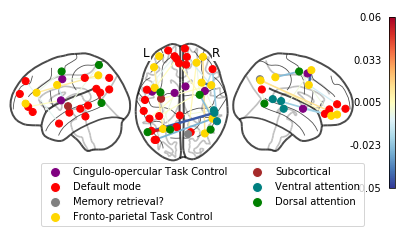

In [15]:
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="RdYlBu_r", axes=axs,
                    display_mode="lzr", colorbar=True, 
                    edge_vmax=0.06, edge_vmin=-0.05)

fig.legend(handles, nets, loc="lower center", ncol=2)
plt.savefig("figures/alpha3_pretty.png", figsize=(7, 4))
plt.show()

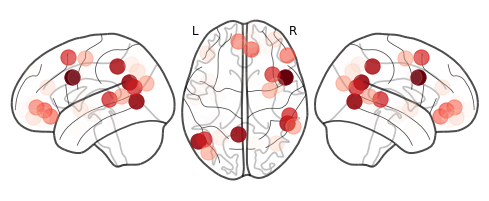

In [14]:
nip.plot_connectome_strength(c, nc, cmap="Reds", display_mode="lzr")
plt.show()